# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  5.0462164878845215


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = imgs0.shape[0]
imgs = imgs0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


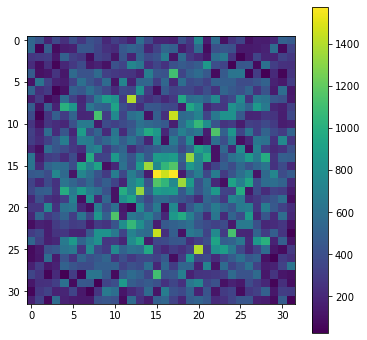

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

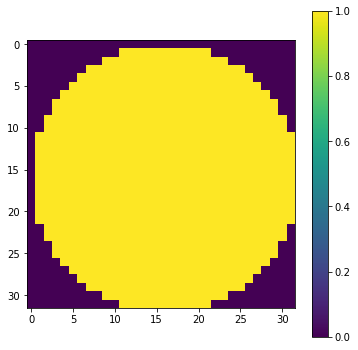

In [12]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

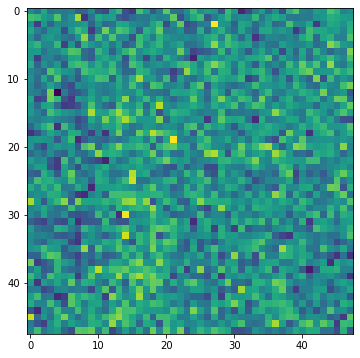

In [13]:
N_noise = 48
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Text(0.5, 1.0, 'Estimated noise')

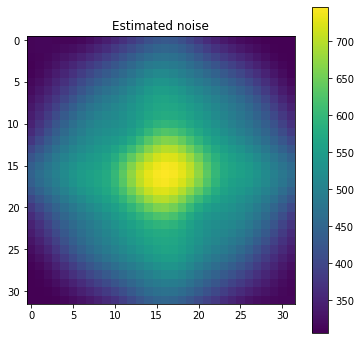

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0, nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

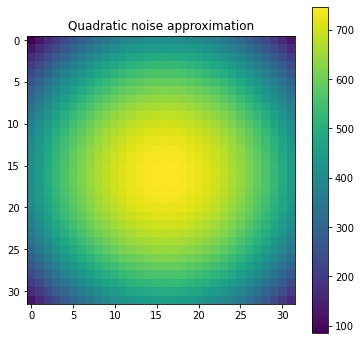

In [15]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

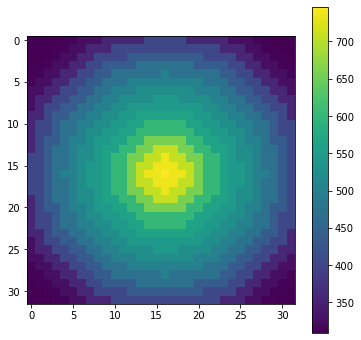

In [16]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

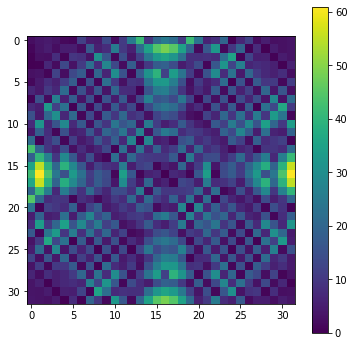

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

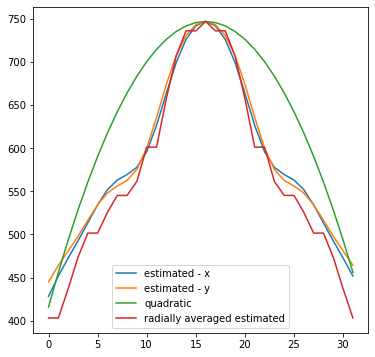

In [18]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])

In [19]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [20]:
del(imgs0)
del(imgs)

### MCMC vol

In [236]:
#alpha = 1e-10
alpha = 1e-6

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs_f, sigma_noise))

In [ ]:
N_mc_samples = 100
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
#v0 = jnp.zeros([nx,nx,nx])*1j
proposal_params_mala = {"tau" : 0.005}
proposal_params_hmc = {"dt" : 0.5, "L" : 10, "M" : M}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, gradLogPi, v0, proposal_params_hmc, 10)

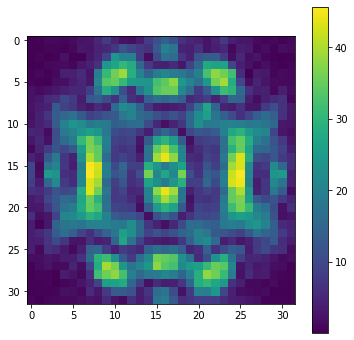

In [239]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

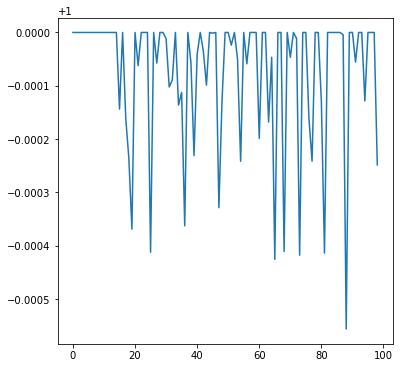

In [240]:
plt.plot(r_hmc)

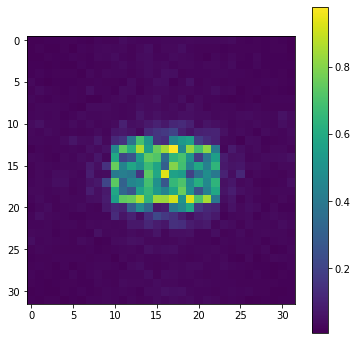

In [234]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [235]:
#with mrcfile.new('../data/reconstruction_data_hmc_vol2.mrc', overwrite=True) as mrc:
#    mrc.set_data(v_hmc_r.astype(np.float32))

### Ab initio

In [24]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [25]:
#sys.stdout = sys.__stdout__

Fourier radius: 0.05021972132474
Starting radius: 0.01
Frequency marching step size: 0.005436444304774993
Number of frequency marching steps: 8
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 1.8793690595332822e-07
  sgd epoch 10: mean gradient = 3.6804994822212284e-08
  sgd epoch 20: mean gradient = 1.170533216577596e-08
  sgd epoch 30: mean gradient = 1.2821348365261145e-08
  sgd epoch 40: mean gradient = 7.366615178359052e-09


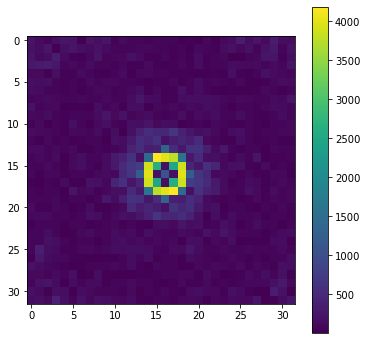

Iter  0
  MC sample 20 , loss = 19.996857712332815
  MC sample 40 , loss = 19.99952171034303
  MC sample 60 , loss = 19.99451755789451
  MC sample 80 , loss = 19.999926823277132
  Time orientations sampling = 3.835692882537842
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 20.4194951565001
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 20.419459379967186
  Iter 60 , a =  0.9999666975135822
  MC sample 60 , loss (of mean) = 20.419448049481378
  Iter 80 , a =  0.9999702271304917
  MC sample 80 , loss (of mean) = 20.41944260207671
  Time vol optimisation = 13.88837718963623
2022-02-24 17:45:01.890101
  nx = 8


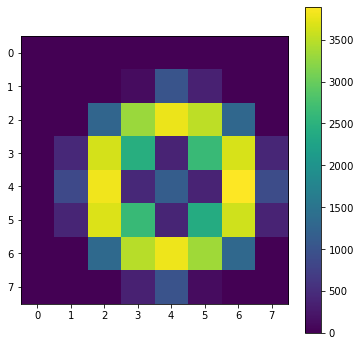

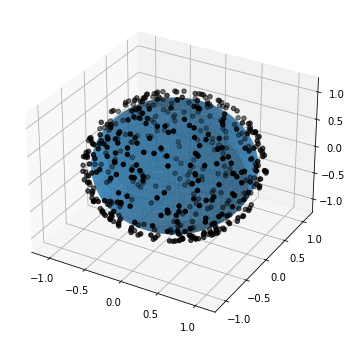

Iter  1
  MC sample 20 , loss = 35.56288330821215
  MC sample 40 , loss = 35.55719275806897
  MC sample 60 , loss = 35.56415509241147
  MC sample 80 , loss = 35.56594654933503
  Time orientations sampling = 4.867170572280884
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 35.75595110975853
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 35.755896641156035
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 35.75588081850639
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 35.755874247710956
  Time vol optimisation = 20.79571771621704
Iter  2
  MC sample 20 , loss = 35.3032814476491
  MC sample 40 , loss = 35.30383484987536
  MC sample 60 , loss = 35.31135958609886
  MC sample 80 , loss = 35.30890320531909
  Time orientations sampling = 5.458304166793823
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 35.70743385794129
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 35.707401368676635
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 35.70738854

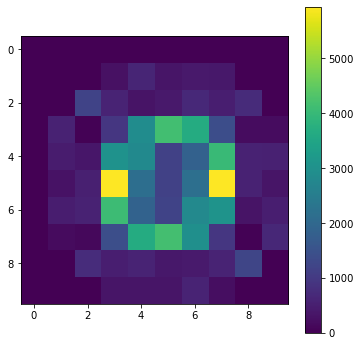

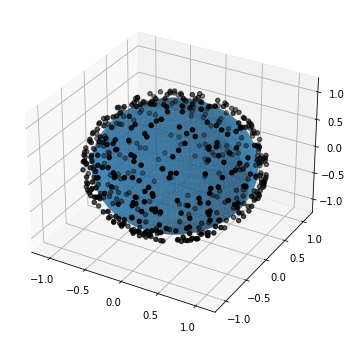

Iter  9
  MC sample 20 , loss = 65.50524787416917
  MC sample 40 , loss = 65.50152532628631
  MC sample 60 , loss = 65.50944494168054
  MC sample 80 , loss = 65.51074931001698
  Time orientations sampling = 6.75297999382019
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 65.42380287975924
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 65.37854825149194
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 65.35721529359374
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 65.3445697489845
  Time vol optimisation = 40.15650749206543
Iter  10
  MC sample 20 , loss = 64.5492974692241
  MC sample 40 , loss = 64.52692430975357
  MC sample 60 , loss = 64.54341599575278
  MC sample 80 , loss = 64.5501460438229
  Time orientations sampling = 6.828164577484131
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 64.90306183011523
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 64.8930542999161
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 64.88697392178972

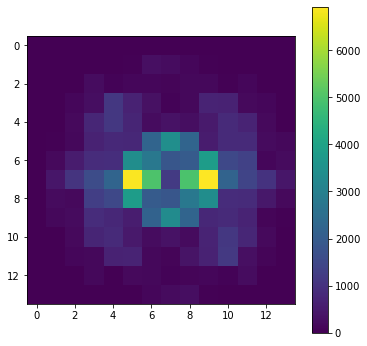

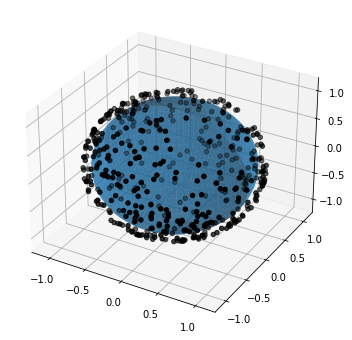

Iter  17
  MC sample 20 , loss = 104.63770925579753
  MC sample 40 , loss = 104.67542415891656
  MC sample 60 , loss = 104.62125281064922
  MC sample 80 , loss = 104.64498979245529
  Time orientations sampling = 8.352685928344727
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 105.04238937626937
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 105.03612693370854
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 105.03329536404843
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 105.03158420860642
  Time vol optimisation = 70.66255378723145
Iter  18
  MC sample 20 , loss = 104.06753936539883
  MC sample 40 , loss = 103.96797427999154
  MC sample 60 , loss = 103.99139258842696
  MC sample 80 , loss = 103.93785922213056
  Time orientations sampling = 8.303349733352661
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 104.41462845917222
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 104.40891229181601
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean)

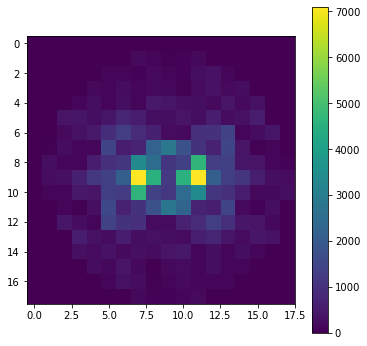

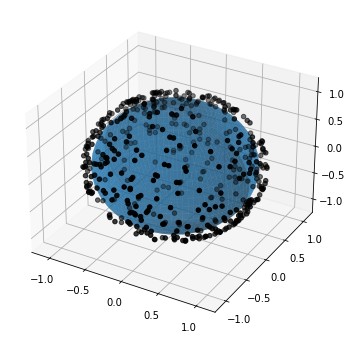

Iter  25
  MC sample 20 , loss = 155.30129535525202
  MC sample 40 , loss = 155.28761056156912
  MC sample 60 , loss = 155.26386217724087
  MC sample 80 , loss = 155.25793907297268
  Time orientations sampling = 11.090126037597656
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 155.19513225385896
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 155.14799673546406
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 155.1208232830315
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 155.10121573552763
  Time vol optimisation = 114.86477613449097
Iter  26
  MC sample 20 , loss = 154.00520050363983
  MC sample 40 , loss = 153.92143349690528
  MC sample 60 , loss = 153.8519562186611
  MC sample 80 , loss = 153.82295418962684
  Time orientations sampling = 10.680002927780151
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 154.28125095097997
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 154.25620161263336
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean

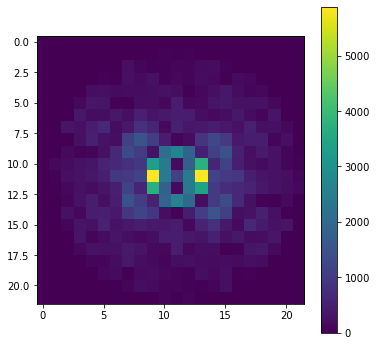

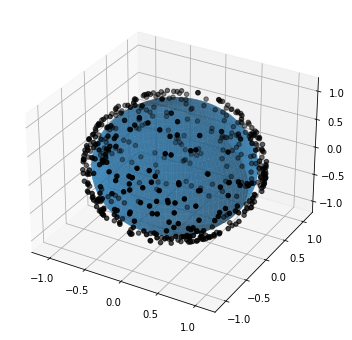

Iter  33
  MC sample 20 , loss = 207.13309073929733
  MC sample 40 , loss = 207.10107890745206
  MC sample 60 , loss = 207.04612962795784
  MC sample 80 , loss = 207.0301624992752
  Time orientations sampling = 12.660207271575928
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 206.16580098367837
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 206.1258515468101
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 206.10702747824965
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 206.09545008879797
  Time vol optimisation = 134.60832357406616
Iter  34
  MC sample 20 , loss = 205.07110253801764
  MC sample 40 , loss = 205.02271520901084
  MC sample 60 , loss = 204.9490514497938
  MC sample 80 , loss = 204.87035888011155
  Time orientations sampling = 11.921529769897461
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 205.52158929942627
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 205.51147310367435
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean)

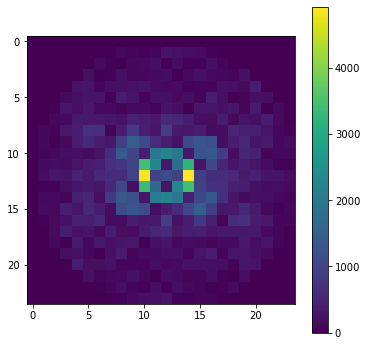

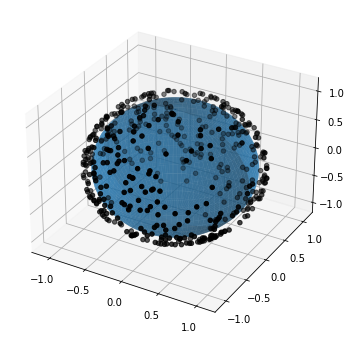

Iter  41
  MC sample 20 , loss = 274.3086959644746
  MC sample 40 , loss = 274.29274366669364
  MC sample 60 , loss = 274.27591195707544
  MC sample 80 , loss = 274.2514167967413
  Time orientations sampling = 14.36842966079712
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 273.17293762346463
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 273.134999853132
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 273.1165006335281
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 273.1048579944468
  Time vol optimisation = 192.50789785385132
Iter  42
  MC sample 20 , loss = 272.1133946592655
  MC sample 40 , loss = 272.07984165504917
  MC sample 60 , loss = 272.0610783099228
  MC sample 80 , loss = 272.02256358465354
  Time orientations sampling = 15.17935061454773
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 272.7740583576304
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 272.7666628400133
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 272.76

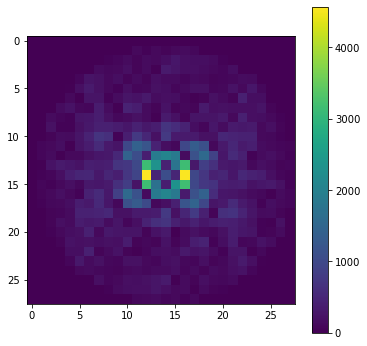

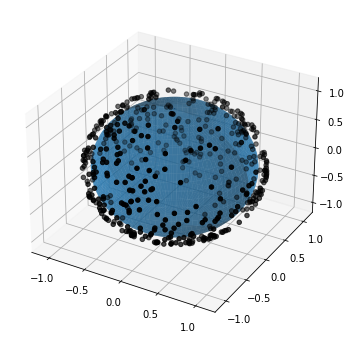

Iter  49
  MC sample 20 , loss = 357.49107475554445
  MC sample 40 , loss = 357.4753811078788
  MC sample 60 , loss = 357.44583423808416
  MC sample 80 , loss = 357.4291784132336
  Time orientations sampling = 17.256255388259888
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 356.4088178132874
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 356.35173924092504
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 356.3243921354353
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 356.307263745367
  Time vol optimisation = 260.3871636390686
Iter  50
  MC sample 20 , loss = 355.2747951192566
  MC sample 40 , loss = 355.2480158869585
  MC sample 60 , loss = 355.2274062338505
  MC sample 80 , loss = 355.20996650947427
  Time orientations sampling = 17.354394912719727
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 356.0586496898653
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 356.0504992512105
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 356.04

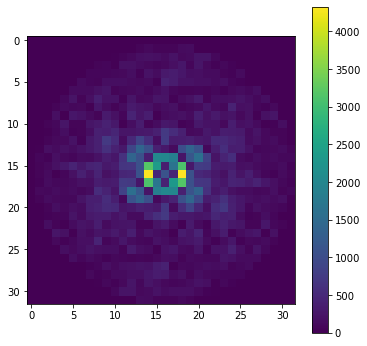

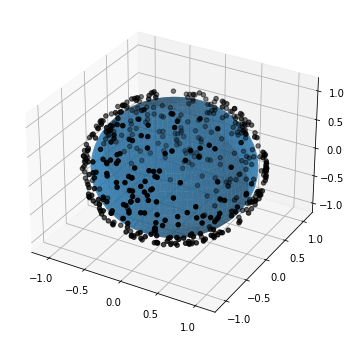

In [23]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations doesn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 10000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6


# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
#eps_gd = 1e-4
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 100
N_samples_vol = 100    

# HMC params
dt = 5
L = 10

#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt, L, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)

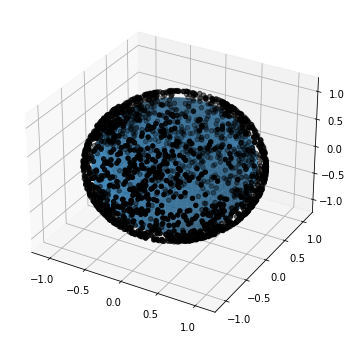

In [24]:
plot_angles(angles_rec[:2000])

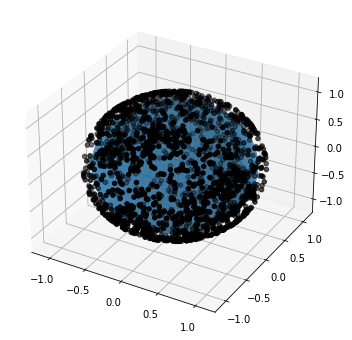

In [32]:
plot_angles(angles_rec[:2000])

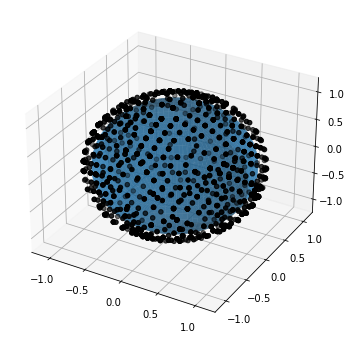

In [33]:
plot_angles(angles[:2000])

### CG - choosing $\alpha$

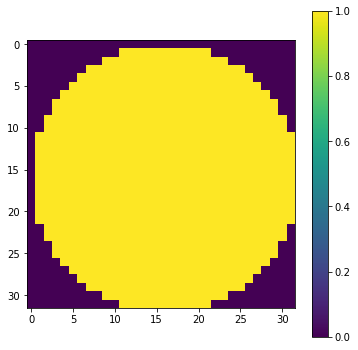

In [101]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [102]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

sigma noise min = 309.3671569824219
sigma noise max = 746.6329956054688
sigma noise mean = 471.57769733667374


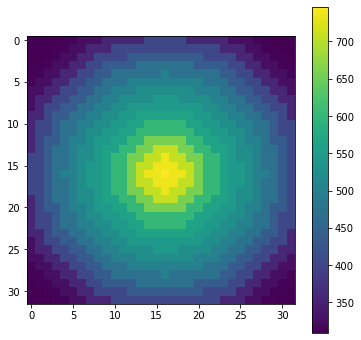

In [103]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [104]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [105]:
N_iter = 50100
eps = 3e-5
#eps = 1e-5
#eps = 1e-3
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [106]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1.1e-06
  cg iter 0 ||r|| = 0.00010695120434695287
  cg iter 10 ||r|| = 2.5394858256747326e-05
  fid = 0.7798959943947431
  reg = 119.5293245794078
  loss = 0.39205171330996913
  Time = 17.003379344940186
alpha = 1e-05
  cg iter 0 ||r|| = 1.2879246612488046e-05
  fid = 0.7873374069026533
  reg = 1.6733864760699484
  loss = 0.3939364452874978
  Time = 9.497883796691895
alpha = 0.0001
  cg iter 0 ||r|| = 1.3016424168687495e-06
  fid = 0.7883053153586516
  reg = 0.017092229741083105
  loss = 0.3941800052469115
  Time = 9.46831727027893
alpha = 0.001
  cg iter 0 ||r|| = 1.3030302815313394e-07
  fid = 0.7884038079445588
  reg = 0.00017128698048380446
  loss = 0.39420464456396714
  Time = 10.379130363464355
alpha = 0.01
  cg iter 0 ||r|| = 1.303169230788465e-08
  fid = 0.7884136744890425
  reg = 1.713235129702346e-06
  loss = 0.3942071113621421
  Time = 9.595714330673218
alpha = 0.1
  cg iter 0 ||r|| = 1.303183127327354e-09
  fid = 0.7884146613166224
  reg = 1.7132716686168196e-08
  

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

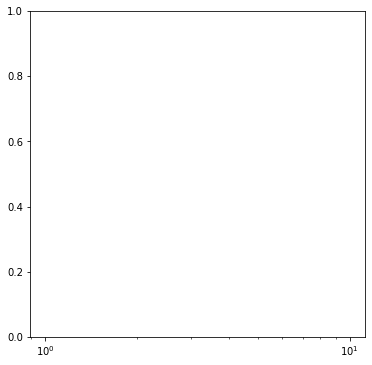

In [108]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [109]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [110]:
alphas[alpha_idx]

DeviceArray(1.1e-06, dtype=float64)

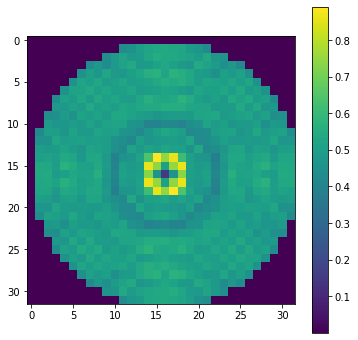

In [111]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

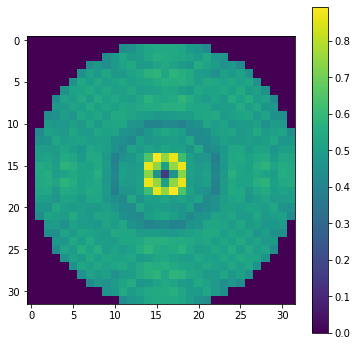

In [112]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [113]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [114]:
#alpha_idx = 2

1.1e-06


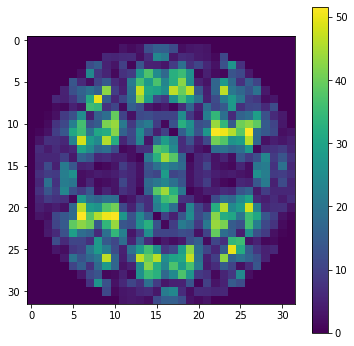

In [115]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

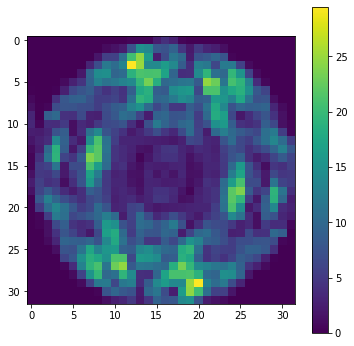

In [116]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

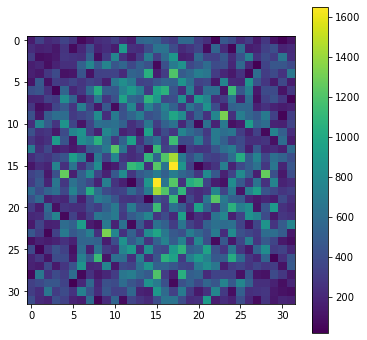

In [117]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

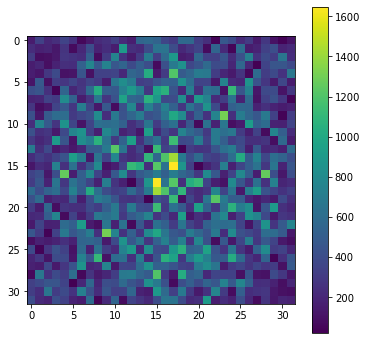

In [118]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [119]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

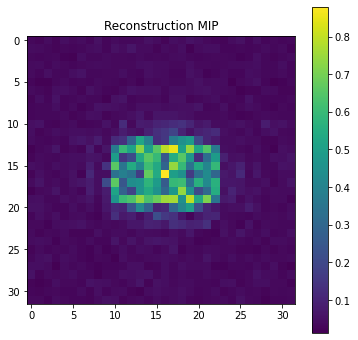

In [120]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [93]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [94]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(10, 32)

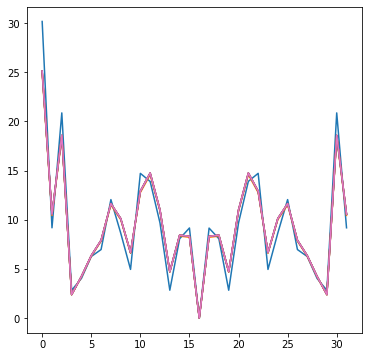

In [124]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [137]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [138]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [127]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


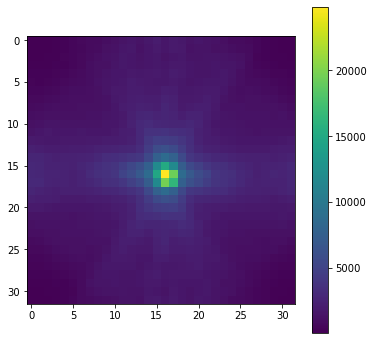

In [128]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [129]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

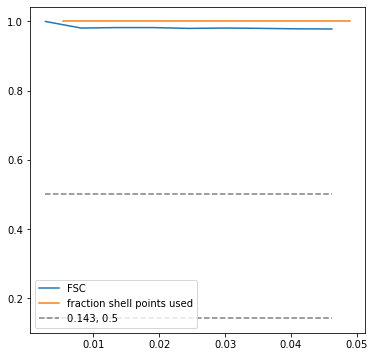

In [139]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

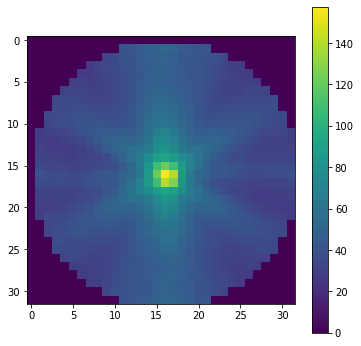

In [140]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

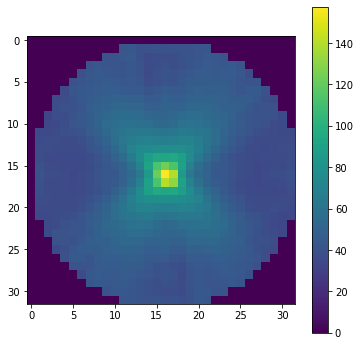

In [141]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

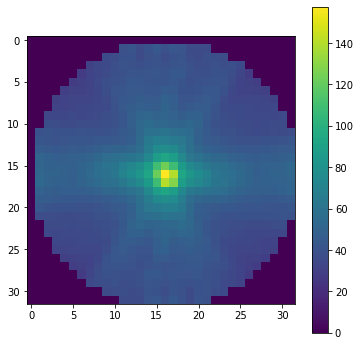

In [142]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [149]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [152]:
jnp.min(jnp.abs(omega))

DeviceArray(0.001, dtype=float64)

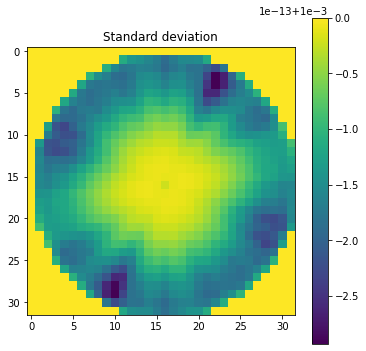

In [171]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

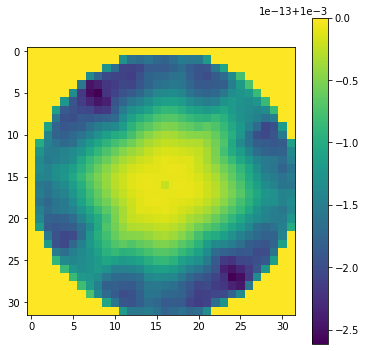

In [172]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

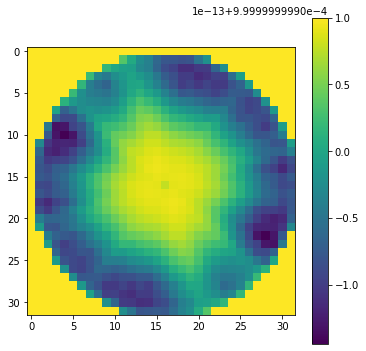

In [173]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

1e-06
1.000001
1e-06


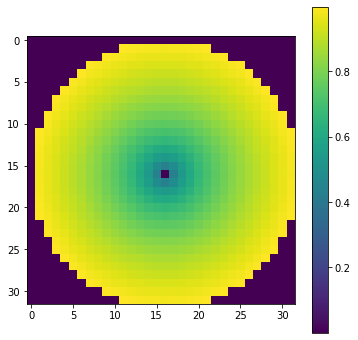

In [174]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


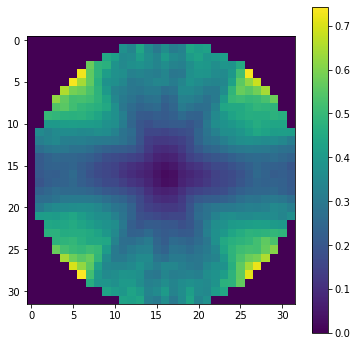

In [175]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [176]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [196]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
alphas = [1e-10, 1e-9, 1e-8, 1e-7]

angles_gd = angles_rec

In [197]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-10
  sgd epoch 0: mean gradient = 1.4729407511529204e-07
  sgd epoch 50: mean gradient = 6.929328984682533e-09
  fid = 0.7156186797013532
  reg = 81203.15309067581
  loss = 0.35793926489562167
  Time = 21.56503438949585
alpha = 1e-09
  sgd epoch 0: mean gradient = 1.478003812584484e-07
  sgd epoch 50: mean gradient = 7.60058385263992e-09
  fid = 0.7158457744341501
  reg = 69454.35128632141
  loss = 0.3590341568376562
  Time = 21.490625143051147
alpha = 1e-08
  sgd epoch 0: mean gradient = 1.41740796721962e-07
  sgd epoch 50: mean gradient = 1.1299338934994461e-08
  sgd epoch 100: mean gradient = 2.5887754490609068e-08
  sgd epoch 150: mean gradient = 1.2294315039249511e-09
  fid = 0.7211072722198489
  reg = 30100.955157007047
  loss = 0.36536978893504557
  Time = 40.72334885597229
alpha = 1e-07
  sgd epoch 0: mean gradient = 6.3791124078498e-08
  sgd epoch 50: mean gradient = 2.4142365269046486e-08
  sgd epoch 100: mean gradient = 3.794820156606282e-08
  sgd epoch 150: mean 

In [203]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

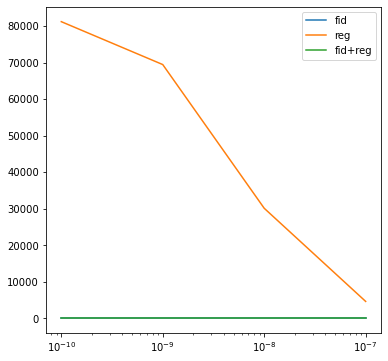

In [204]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

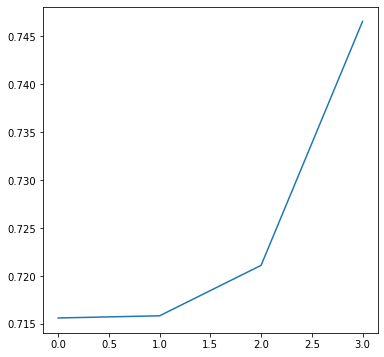

In [205]:
plt.plot(fids)

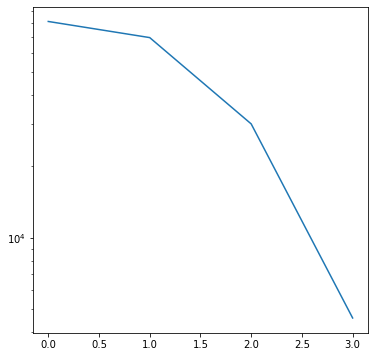

In [206]:
plt.semilogy(regs)

In [207]:
alphas[2]

DeviceArray(1.e-08, dtype=float64)

In [208]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

0.6971769473547622


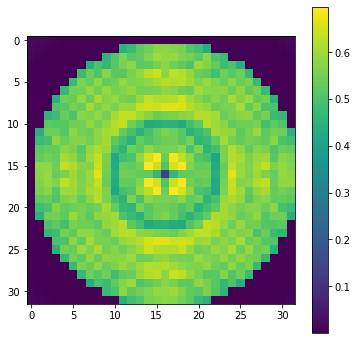

In [209]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.6971769473547622


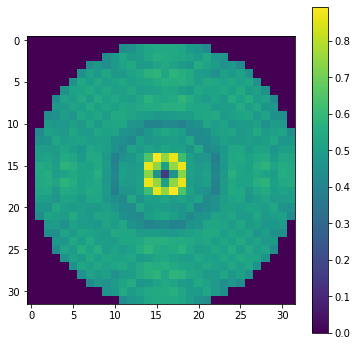

In [210]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

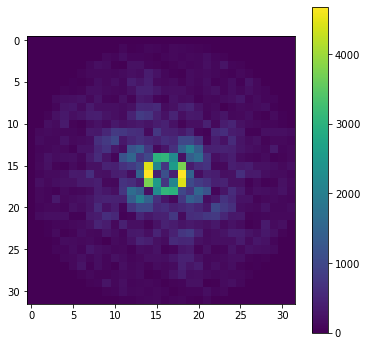

In [213]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

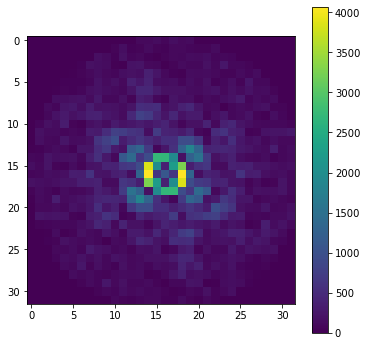

In [214]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

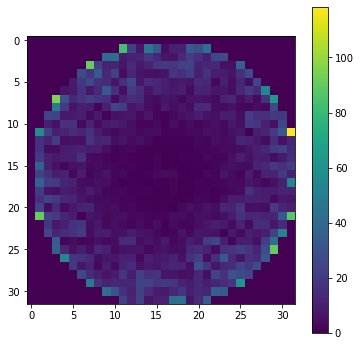

In [217]:
err = vgds[1] - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

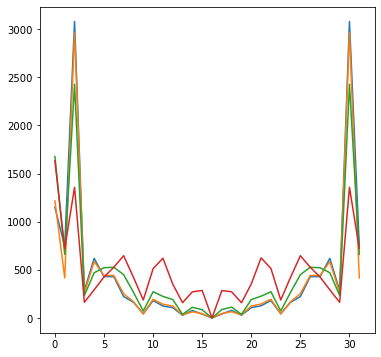

In [227]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


Text(0.5, 1.0, 'Reconstruction MIP')

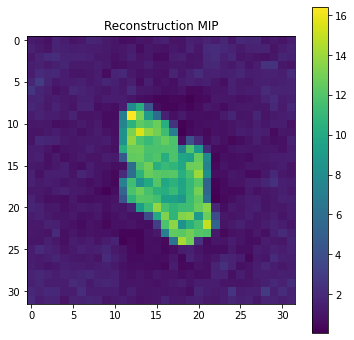

In [228]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

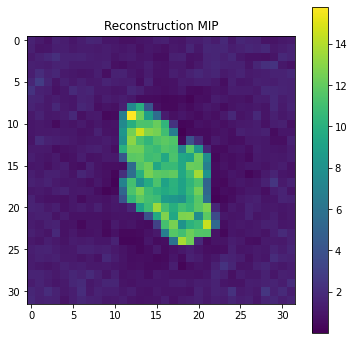

In [229]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [240]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [231]:
idx = 100

In [236]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

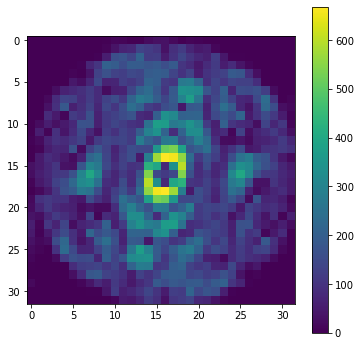

In [237]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

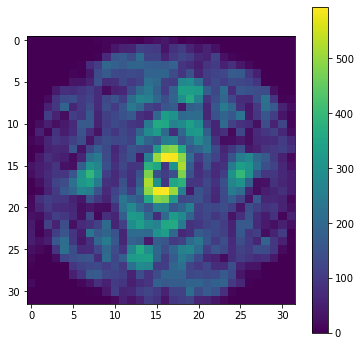

In [238]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

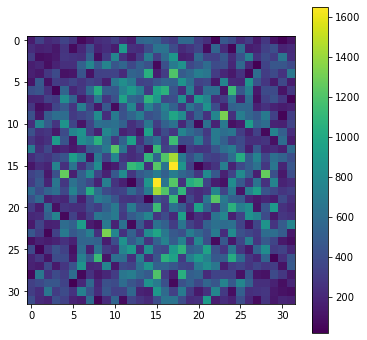

In [239]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()